# Phishing email detection - Step 2
**Chloé MIGAUD**  

**Dataset:** [Kaggle — Phishing Email Dataset](https://www.kaggle.com/datasets/subhajournal/phishingemails)  
**Goal:** The goal of this step is to improve our phishing email classifier by testing different hyperparameters and trying ensemble methods. This helps us boost the model’s accuracy and make its predictions more stable.



In [33]:
# Imports 
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Same clean_text as in the step1
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' url ', text)   # mark links
    text = re.sub(r'[^a-z\s]', ' ', text)     # keep letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # tidy spaces
    return text

df['clean_text'] = df['Email Text'].apply(clean_text)

# Encode labels: Safe -> 0, Phishing -> 1 
df['label'] = (df['Email Type'].str.lower().str.contains('phishing')).astype(int)

# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Fit on train, transform on test
# Convert text into numeric features so the model can learn from it
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train) # learn vocabulary from training set 
X_test_tfidf = vectorizer.transform(X_test)

TF-IDF is a way to convert text into numbers so that machine learning models can understand it.  
- TF (Term Frequency): how often a word appears in the email (like "urgent", "money", "free", ...)  
- IDF (Inverse Document Frequency): reduces the importance of very common words (like "hello", "Dear", "and",...)  

So TF-IDF gives high weight to important and distinctive words and low weight to generic words.  

This makes it easier for the model to detect patterns and classify emails as Safe or Phishing.  

**1) Hyperparameter tuning for Logistic Regression (GridSearchCV)**  

I am using GridSearchCV to find the best possible version of the Logistic Regression model.  
I gave it a “list of possible choices” (called parameter grid) and GridSearch tests all combinations to find the one that predicts best.

In [9]:
# 1) Hyperparameter tuning for Logistic Regression (GridSearchCV)

# Base Logistic Regression model (same type as Step 1)
log_reg = LogisticRegression(max_iter=300, n_jobs=-1)

# Parameter grid: we keep it small to avoid long training time
param_grid_lr = {
    "C": [0.1, 1, 10],             # strength of regularization
    "class_weight": [None, "balanced"], # handle class imbalance
    "penalty": ["l2"],            
    "solver": ["lbfgs"]           
}

# GridSearchCV tries all combinations and selects the best one
grid_lr = GridSearchCV(
    estimator=log_reg,           # baseline model
    param_grid=param_grid_lr,    # search space
    scoring="f1",                # focus on F1 score (important for phishing)
    cv=5,                        # 5-fold cross-validation
    n_jobs=-1,                   # use all CPU cores
    verbose=1                    # show progress
)

# Fit grid search on the training data (TF-IDF features)
grid_lr.fit(X_train_tfidf, y_train)

# Extract the best logistic regression model
best_lr = grid_lr.best_estimator_

print("Best LR params:", grid_lr.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best LR params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


=> GridSearch evaluated 30 models and found that the best model uses C = 10, class_weight = "balanced", L2 regularization, and the lbfgs solver.

**2) Hyperparameter tuning for Linear SVM (GridSearchCV)**  
An SVM is a classification model that seeks the best possible boundary to separate two classes (Safe Email/Phishing Email).  
This boundary is a line (in 2D), a plane (in 3D), or a hyperplane (in TF-IDF space).  

The goal is to find a boundary that best separates the two classes while leaving maximum space between them.  
This space = the margin => the larger it is, the more robust the model is.  

In [15]:
# 2) Hyperparameter tuning for Linear SVM (GridSearchCV)

# Baseline SVM model
svm = LinearSVC()

# Parameter grid: only tuning C to keep it fast
param_grid_svm = {
    "C": [0.1, 1, 10]     # regularization strength
}

# Grid search configuration for SVM
grid_svm = GridSearchCV(
    estimator=svm,             # SVM model
    param_grid=param_grid_svm, # grid to search
    scoring="f1",              # F1-score to focus on phishing detection
    cv=5,                      # 5-fold cross validation
    n_jobs=-1,                 # use all CPU cores
    verbose=1                  # show progress
)

# Fit grid search on training features
grid_svm.fit(X_train_tfidf, y_train)

# Extract the best SVM model
best_svm = grid_svm.best_estimator_
print("Best SVM params:", grid_svm.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best SVM params: {'C': 1}


C:\Users\ChloéMigaud\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


GridSearch evaluated 3 SVM configurations (C = 0.1, 1, 10) with 5-fold cross-validation, leading to 15 total fits. The best hyperparameter is C = 1, meaning the model works best with moderate regularization.

**3) Voting Classifier**  
The Voting Classifier is an ensemble model => it combines several models and chooses the prediction by majority vote.  

In this case, we combine:
- Logistic Regression (tuned)
- SVM (tuned)

Each model predicts safe or phi hing.
The Voting Classifier looks at both predictions and chooses the most voted class.

In [17]:
# 3) Ensemble model: Voting Classifier (LR + SVM)

# Voting classifier (hard voting = majority vote)
voting_clf = VotingClassifier(
    estimators=[
        ("lr", best_lr),     # best logistic regression model
        ("svm", best_svm)    # best SVM model
    ],
    voting="hard"            # choose the class predicted by most models
)

# Train the ensemble model
voting_clf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_vote = voting_clf.predict(X_test_tfidf)

print("Voting classifier ready")


Voting classifier ready


C:\Users\ChloéMigaud\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


**4) Ensemble model : Bagging**  
Bagging (Bootstrap Aggregating) is an ensemble method that creates multiple versions of the same model and then combines their predictions.  

In our cas  :

- We use 10 Logistic Regression mo  dels
- Each is trained on 80% of the dataset (selected randomly with replace  ment)
- The final model makes a prediction based on the average of the 10 r  esults

In [24]:
# 4) Ensemble model: Bagging (using Logistic Regression)

# Bagging with Logistic Regression
bagging_lr = BaggingClassifier(
    estimator=best_lr,  # reuse the best LR model
    n_estimators=10,         # create 10 models
    max_samples=0.8,         # each model sees 80% of the data
    random_state=42,
    n_jobs=-1                # use all CPU cores
)

# Train the bagging ensemble
bagging_lr.fit(X_train_tfidf, y_train)

# Predictions on test set
y_pred_bag = bagging_lr.predict(X_test_tfidf)

print("Bagging classifier ready")


Bagging classifier ready


Why use Bagging?  

=>reduces overfitting  
=>makes predictions more stable  
=>compensates for errors in a single model  
=>useful when a model tends to vary depending on the data  
  
In our case, Bagging helps stabilize Logistic Regression, but since LR is already very stable on TF-IDF, the improvement is slight, but robustness increases.

**5) Evaluation of models**  
`plot_cm()` is a small helper function that draws the confusion matrix as a heatmap.  
The confusion matrix allows us to see:  
- how many emails were correctly classified as Safe  
- how many were correctly classified as Phishing  
- and where the model made mistakes  

It helps visualize model errors and understand where the classifier struggles (false positives, false negatives).

In [28]:
# 5) Evaluation of models: classification report + heatmap

# ------------------------------------------------------------
# Helper function to display a confusion matrix as a heatmap
# ------------------------------------------------------------
def plot_cm(y_true, y_pred, title):
    """
    Plot confusion matrix for any classifier.
    - y_true: ground-truth labels
    - y_pred: model predictions
    - title: figure title
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Pred Safe", "Pred Phishing"],
        yticklabels=["True Safe", "True Phishing"]
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

=== Tuned Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2264
           1       0.93      0.97      0.95      1466

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



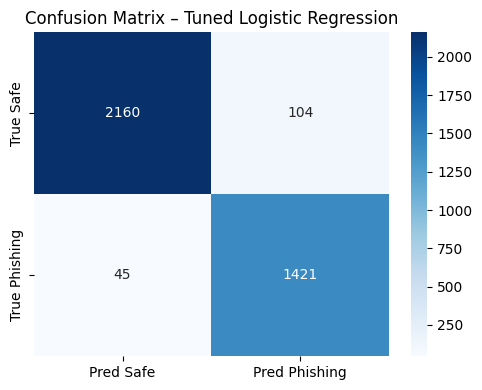

In [29]:
# ------------------------------------------------------------
#  Evaluate Tuned Logistic Regression
# ------------------------------------------------------------
print("=== Tuned Logistic Regression ===")
y_pred_lr = best_lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_lr))

plot_cm(
    y_test,
    y_pred_lr,
    "Confusion Matrix – Tuned Logistic Regression"
)

=> The tuned Logistic Regression model performs very well:  
- It correctly identifies most phishing emails (97% recall)  
- It also makes very few mistakes on safe emails.  
- Only **104 Safe emails were misclassified as Phishing** (false positives)  
- Only **45 Phishing emails were misclassified as Safe** (false negatives : dangerous type of error)  
- Overall accuracy is 96%, which is strong and balanced.  


=== Tuned Linear SVM ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2264
           1       0.93      0.96      0.95      1466

    accuracy                           0.96      3730
   macro avg       0.95      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



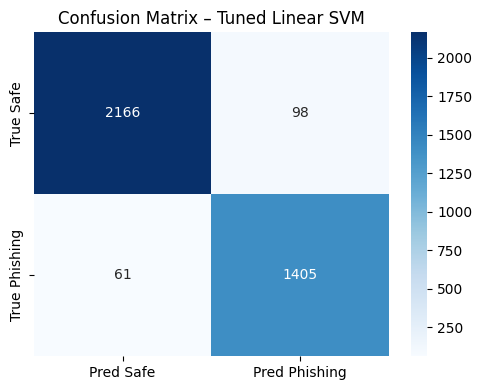

In [30]:
# ------------------------------------------------------------
#  Evaluate Tuned Linear SVM
# ------------------------------------------------------------
print("\n=== Tuned Linear SVM ===")
y_pred_svm = best_svm.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm))

plot_cm(
    y_test,
    y_pred_svm,
    "Confusion Matrix – Tuned Linear SVM"
)


The tuned Linear SVM reaches an accuracy of 96%, very close to the optimized Logistic Regression. It detects phishing emails very well (recall = 0.96), with only 61 missed phishing emails. It still makes some mistakes on Safe emails (98 false alarms), but overall the model remains stable and reliable.


=== Bagging Ensemble (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2264
           1       0.93      0.97      0.95      1466

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



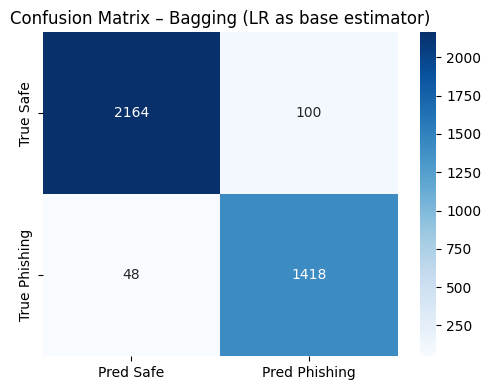

In [31]:
# ------------------------------------------------------------
#  Evaluate Bagging Ensemble (using tuned LR)
# ------------------------------------------------------------
print("\n=== Bagging Ensemble (Logistic Regression) ===")
y_pred_bag = bagging_lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_bag))

plot_cm(
    y_test,
    y_pred_bag,
    "Confusion Matrix – Bagging (LR as base estimator)"
)

The Bagging model built on top of Logistic Regression shows slightly better stability. Overall accuracy stays around 96%, but it reduces the number of errors, especially phishing errors (48 false negatives instead of 56 in the tuned LR).

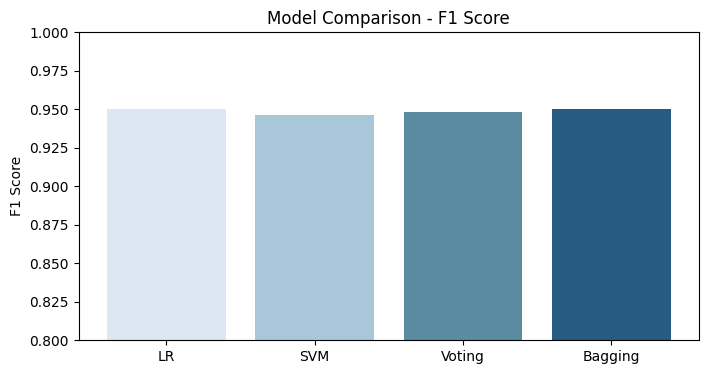

F1 scores:
LR: 0.9501838849882982
SVM: 0.9464466150218929
Voting: 0.9480081026333559
Bagging: 0.9504021447721179


In [36]:
# 6) Model comparison (F1-score bar plot)

# Compute F1 scores for each model
f1_lr   = f1_score(y_test, y_pred_lr)
f1_svm  = f1_score(y_test, y_pred_svm)
f1_vote = f1_score(y_test, y_pred_vote)
f1_bag  = f1_score(y_test, y_pred_bag)

# List of model names and scores
models = ["LR", "SVM", "Voting", "Bagging"]
scores = [f1_lr, f1_svm, f1_vote, f1_bag]

# Plot
plt.figure(figsize=(8,4))
plt.bar(models, scores, color=["#dce7f3", "#a8c7d9", "#5a8ba1", "#265c82"])
plt.ylim(0.8, 1.0)
plt.title("Model Comparison - F1 Score")
plt.ylabel("F1 Score")
plt.show()

# Print scores for clarity
print("F1 scores:")
print("LR:", f1_lr)
print("SVM:", f1_svm)
print("Voting:", f1_vote)
print("Bagging:", f1_bag)


All the models obtain very similar F1-scores, around 0.95, thay shows that the dataset is quite easy to separate using TF-IDF features.  
Logistic Regression remains one of the best, even after tuning.  
SVM performs almost the same, just slightly lower.  
Voting and Bagging do not bring big improvements, meaning the base models are already very strong.  